## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from best_models import models_to_cv
from cross_validation import cross_validation

## Setup

In [5]:
np.random.seed(42)

In [6]:
train_data = pd.read_csv('../data/train_winsor_1_norm.csv')
X_train = train_data.drop(columns='class')
y_train = train_data['class']

In [7]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_train_ad, y_train_ad = adasyn.fit_resample(X_train, y_train)
y_train_ad.value_counts()

class
1    8659
0    7809
Name: count, dtype: int64

In [84]:
val_data = pd.read_csv('../data/validation_winsor_1_norm.csv')
X_val = val_data.drop(columns='class')
y_val = val_data['class']

In [85]:
test_data = pd.read_csv('../data/teste.csv')
X_test = test_data.drop(columns='class')
y_test = test_data['class']

In [86]:
y_train.value_counts()

class
1    8659
0    4574
Name: count, dtype: int64

In [87]:
y_test.value_counts()

class
1    1809
0    1027
Name: count, dtype: int64

In [88]:
y_val.value_counts()

class
1    1864
0     972
Name: count, dtype: int64

In [89]:
best_trials = {}
model_names = ['KNN','DTR', 'SVM', 'RF', 'XGB', 'LGBM', 'MLP', 'LVQ']

In [90]:
best_models, ensembles = models_to_cv()

In [91]:
def calculate_loacc(y_true, y_scores):

    from sklearn.metrics import roc_curve
    
    # Calcula a curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    # Valores de aceitação do fundo específicos
    thresholds = [0.01, 0.02, 0.05]
    
    # Interpolação linear para calcular TPR nos thresholds desejados
    loacc_values = []
    for t in thresholds:
        for i in range(len(fpr) - 1):
            if fpr[i] <= t < fpr[i + 1]:  # Encontrar o intervalo [FPR[i], FPR[i+1]]
                interp_value = ((tpr[i+1] - tpr[i]) / (fpr[i+1] - fpr[i])) * (t - fpr[i]) + tpr[i]
                loacc_values.append(interp_value)
                break

    # Calcula a média dos valores de TPR encontrados
    loacc = sum(loacc_values) / len(thresholds)
    return loacc

In [92]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
import statistics as st
from imblearn.over_sampling import ADASYN

def stress_testing(X_train, y_train, X_test, y_test, pipelines, use_adasyn=False):
    if use_adasyn == True:
        adasyn = ADASYN(sampling_strategy='auto', random_state=42)
        X_train, y_train = adasyn.fit_resample(X_train, y_train)
            
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Lists to store the metrics
    test_metrics = {
        'model_name': [],
        'ACSA': [],
        'recall': [],
        'CM': [],
        'f1_score': [],
        'training_time': [],
        'inference_time': [],
        'error_rate': [],
        'train_accuracy': [],
        'test_accuracy': [],
        'precision': [],
        'loacc': [],
        'auc': []
    }

    for model_name, pipeline in pipelines.items():
        print(f'Model {model_name}')

        start_train = time.time()
        fitted_model = pipeline.fit(X_train, y_train)
        stop_train = time.time()
        training_time = stop_train - start_train

        # Train and test predictions
        y_train_pred = fitted_model.predict(X_train)
        start_test = time.time()
        y_test_pred = fitted_model.predict(X_test)
        stop_test = time.time()
        inference_time = stop_test - start_test

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        error_rate = 1 - test_accuracy  # Error rate is 1 - accuracy
        rec = recall_score(y_test, y_test_pred)
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        class_accuracies = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
        acsa = class_accuracies.mean()

        y_scores = pipeline.predict_proba(X_test)[:, 1]

        loacc = calculate_loacc(y_test,y_scores)            

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_value = auc(fpr, tpr)

        # Storing metrics
        test_metrics['train_accuracy'].append(train_accuracy)
        test_metrics['test_accuracy'].append(test_accuracy)
        test_metrics['f1_score'].append(f1)
        test_metrics['precision'].append(prec)
        test_metrics['error_rate'].append(error_rate)
        test_metrics['recall'].append(rec)
        test_metrics['model_name'].append(model_name)
        test_metrics['ACSA'].append(acsa)
        test_metrics['CM'].append(conf_matrix)
        test_metrics['training_time'].append(training_time)
        test_metrics['inference_time'].append(inference_time)
        test_metrics['loacc'].append(loacc)
        test_metrics['auc'].append(auc_value)
                    
    metrics = pd.DataFrame(test_metrics)

    if use_adasyn == True:
        metrics.to_csv(f'../metrics_correct/metrics_stress_test_adasyn.csv', index=False)
    else:
        metrics.to_csv(f'../metrics_correct/metrics_stress_test.csv', index=False)

    print(f'\n Metrics: \n{metrics}')
    
    return metrics

## Imports

In [93]:
best_models, ensembles = models_to_cv()

In [94]:
best_models.update(ensembles)

In [100]:
val_metrics_with_adasyn = stress_testing(X_train, y_train, X_val, y_val, best_models, use_adasyn=True)
val_metrics_with_adasyn

Model KNN
Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model RF
Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 8659, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 16468, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525808 -> initscore=0.103322
[LightGBM] [Info] Start training from score 0.103322
Model MLP
Model Heterogêneo
[LightGBM] [Info] Number of positive: 8659, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 16468, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525808 -> initscore=0.103322
[LightGBM] [Inf

c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Metrics: 
    model_name      ACSA    recall                         CM  f1_score  \
0          KNN  0.804554  0.813841  [[773, 199], [347, 1517]]  0.847486   
1          LVQ  0.520162  0.042382     [[970, 2], [1785, 79]]  0.081234   
2          DTR  0.789586  0.836373  [[722, 250], [305, 1559]]  0.848897   
3          SVM  0.718611  0.787017  [[632, 340], [397, 1467]]  0.799237   
4           RF  0.857628  0.893240  [[799, 173], [199, 1665]]  0.899514   
5          XGB  0.861251  0.894313  [[805, 167], [197, 1667]]  0.901568   
6         LGBM  0.859818  0.899678  [[797, 175], [187, 1677]]  0.902583   
7          MLP  0.852800  0.883584  [[799, 173], [217, 1647]]  0.894137   
8  Heterogêneo  0.861005  0.894850  [[804, 168], [196, 1668]]  0.901622   
9         ANNs  0.855511  0.865343  [[822, 150], [251, 1613]]  0.889440   

   training_time  inference_time  error_rate  train_accuracy  test_accuracy  \
0       0.000879        0.177722    0.192525        0.877216       0.807475   
1   

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision,loacc,auc
0,KNN,0.804554,0.813841,"[[773, 199], [347, 1517]]",0.847486,0.000879,0.177722,0.192525,0.877216,0.807475,0.884033,0.275062,0.884120
1,LVQ,0.520162,0.042382,"[[970, 2], [1785, 79]]",0.081234,35.218904,0.144560,0.630113,0.495264,0.369887,0.975309,0.108727,0.531624
2,DTR,0.789586,0.836373,"[[722, 250], [305, 1559]]",0.848897,0.041134,0.000999,0.195698,0.814185,0.804302,0.861802,0.114851,0.848582
3,SVM,0.718611,0.787017,"[[632, 340], [397, 1467]]",0.799237,4.955641,0.367169,0.259873,0.667598,0.740127,0.811843,0.209227,0.804915
4,RF,0.857628,0.893240,"[[799, 173], [199, 1665]]",0.899514,19.866574,0.128717,0.131171,0.989738,0.868829,0.905876,0.414700,0.927795
5,XGB,0.861251,0.894313,"[[805, 167], [197, 1667]]",0.901568,21.803396,0.021268,0.128350,0.950874,0.871650,0.908942,0.409871,0.931542
6,LGBM,0.859818,0.899678,"[[797, 175], [187, 1677]]",0.902583,0.351508,0.004000,0.127645,0.953911,0.872355,0.905508,0.429900,0.929728
7,MLP,0.852800,0.883584,"[[799, 173], [217, 1647]]",0.894137,51.848126,0.047065,0.137518,0.832524,0.862482,0.904945,0.423999,0.924764
8,Heterogêneo,0.861005,0.894850,"[[804, 168], [196, 1668]]",0.901622,121.139909,0.029528,0.128350,0.956036,0.871650,0.908497,0.425787,0.930700
9,ANNs,0.855511,0.865343,"[[822, 150], [251, 1613]]",0.889440,81.381742,0.086133,0.141396,0.832038,0.858604,0.914918,0.423999,0.927608


In [101]:
test_metrics_with_adasyn = stress_testing(X_train, y_train, X_test, y_test, best_models, use_adasyn=True)
test_metrics_with_adasyn

Model KNN


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model RF


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 8659, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 16468, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525808 -> initscore=0.103322
[LightGBM] [Info] Start training from score 0.103322
Model MLP


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Heterogêneo
[LightGBM] [Info] Number of positive: 8659, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 16468, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525808 -> initscore=0.103322
[LightGBM] [Info] Start training from score 0.103322
[LightGBM] [Info] Number of positive: 6927, number of negative: 6247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 13174, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525808 -> initscore=0.103325
[LightGBM] [Info] Start training from score 0.103325
[L

c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Metrics: 
    model_name      ACSA    recall                         CM  f1_score  \
0          KNN  0.500000  0.000000     [[1027, 0], [1809, 0]]  0.000000   
1          LVQ  0.574179  0.945826   [[208, 819], [98, 1711]]  0.788661   
2          DTR  0.504975  0.009950    [[1027, 0], [1791, 18]]  0.019704   
3          SVM  0.500000  0.000000     [[1027, 0], [1809, 0]]  0.000000   
4           RF  0.500000  0.000000     [[1027, 0], [1809, 0]]  0.000000   
5          XGB  0.503593  0.007186    [[1027, 0], [1796, 13]]  0.014270   
6         LGBM  0.500553  0.001106     [[1027, 0], [1807, 2]]  0.002209   
7          MLP  0.717786  0.631288  [[826, 201], [667, 1142]]  0.724619   
8  Heterogêneo  0.500553  0.001106     [[1027, 0], [1807, 2]]  0.002209   
9         ANNs  0.726141  0.628524  [[846, 181], [672, 1137]]  0.727215   

   training_time  inference_time  error_rate  train_accuracy  test_accuracy  \
0       0.002001        0.199633    0.637870        0.877216       0.362130   
1   

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision,loacc,auc
0,KNN,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,0.002001,0.199633,0.637870,0.877216,0.362130,0.000000,0.047800,0.510851
1,LVQ,0.574179,0.945826,"[[208, 819], [98, 1711]]",0.788661,97.014497,0.281320,0.323343,0.495264,0.676657,0.676285,0.044776,0.568114
2,DTR,0.504975,0.009950,"[[1027, 0], [1791, 18]]",0.019704,0.058788,0.000000,0.631523,0.824933,0.368477,1.000000,0.035478,0.504774
3,SVM,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,11.041356,0.473804,0.637870,0.667598,0.362130,0.000000,0.026667,0.500000
4,RF,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,22.633551,0.064118,0.637870,0.989191,0.362130,0.000000,0.063553,0.592582
5,XGB,0.503593,0.007186,"[[1027, 0], [1796, 13]]",0.014270,24.301253,0.014883,0.633286,0.950328,0.366714,1.000000,0.058208,0.554399
6,LGBM,0.500553,0.001106,"[[1027, 0], [1807, 2]]",0.002209,0.506972,0.004012,0.637165,0.953911,0.362835,1.000000,0.074546,0.588126
7,MLP,0.717786,0.631288,"[[826, 201], [667, 1142]]",0.724619,55.161299,0.061962,0.306065,0.830823,0.693935,0.850335,0.096004,0.785706
8,Heterogêneo,0.500553,0.001106,"[[1027, 0], [1807, 2]]",0.002209,124.748725,0.016037,0.637165,0.955732,0.362835,1.000000,0.073153,0.580953
9,ANNs,0.726141,0.628524,"[[846, 181], [672, 1137]]",0.727215,128.331035,0.089992,0.300776,0.833495,0.699224,0.862671,0.101470,0.772019


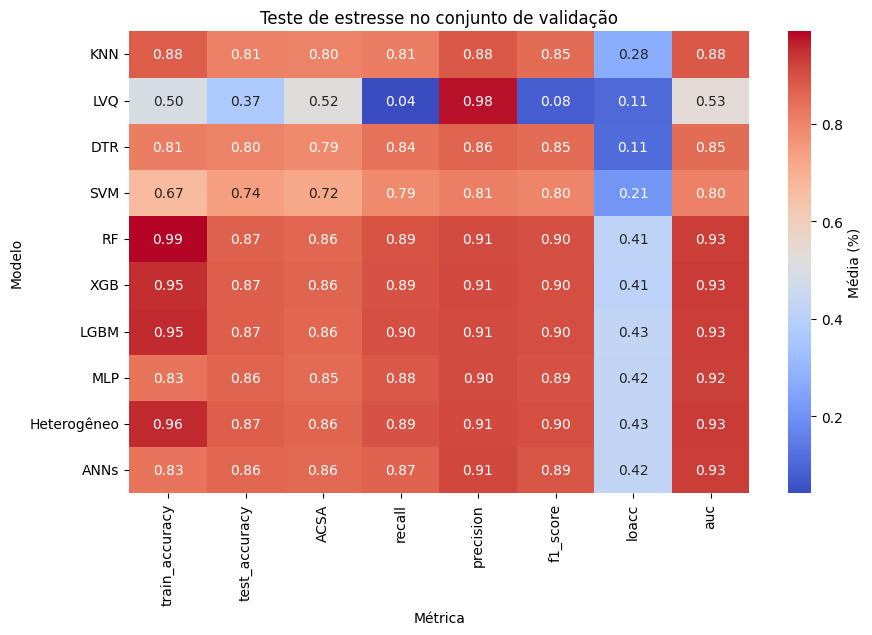

In [130]:
filtered_data = val_metrics_with_adasyn[['train_accuracy', 'test_accuracy', 'ACSA', 'recall', 'precision', 'f1_score', 'loacc', 'auc']]
filtered_data.index = val_metrics_with_adasyn['model_name']
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Média (%)'})
plt.title("Teste de estresse no conjunto de validação")
plt.xlabel("Métrica")
plt.ylabel("Modelo")
plt.show()

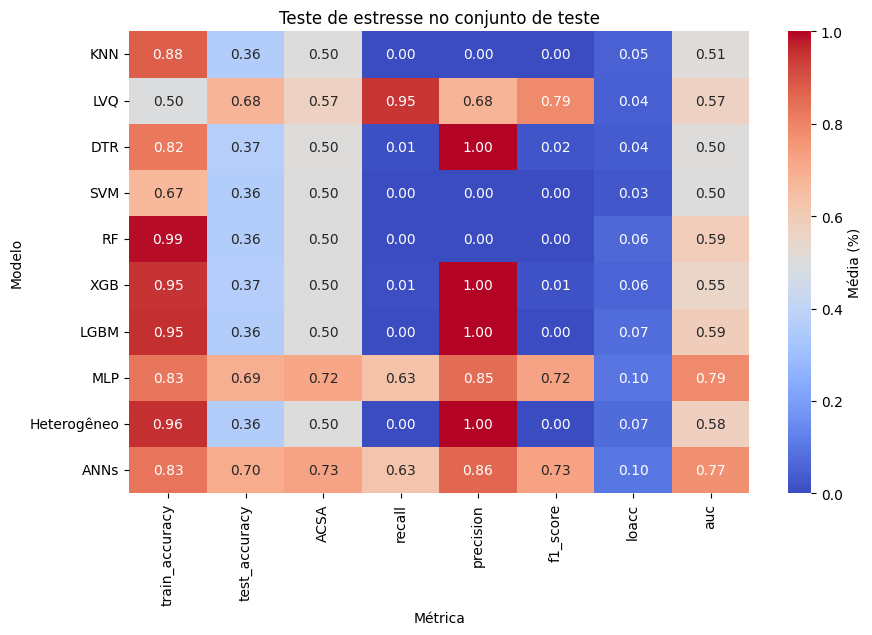

In [131]:
filtered_data = test_metrics_with_adasyn[['train_accuracy', 'test_accuracy', 'ACSA', 'recall', 'precision', 'f1_score', 'loacc', 'auc']]
filtered_data.index = val_metrics_with_adasyn['model_name']

plt.figure(figsize=(10, 6))
sns.heatmap(filtered_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Média (%)'})
plt.title("Teste de estresse no conjunto de teste")
plt.xlabel("Métrica")
plt.ylabel("Modelo")
plt.show()

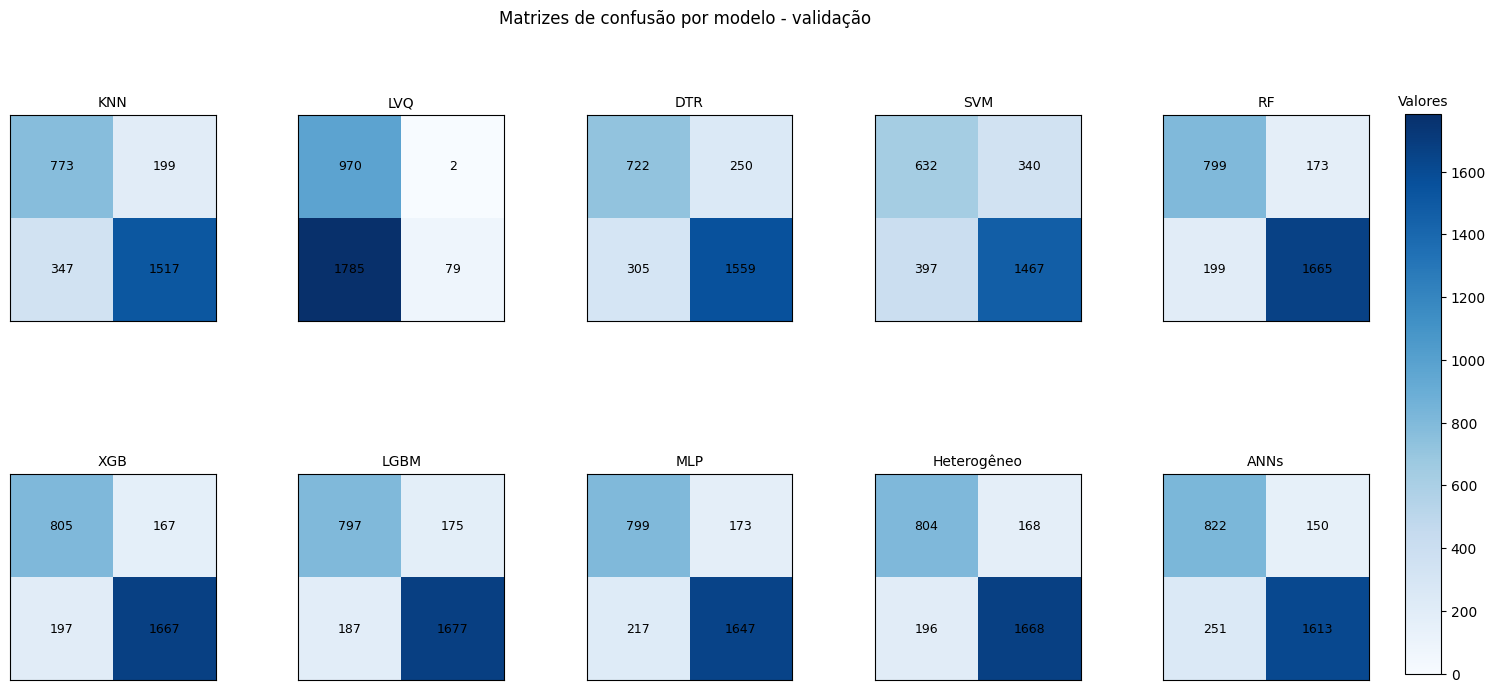

In [117]:
confusion_matrices = val_metrics_with_adasyn['CM']
models = val_metrics_with_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - validação')

plt.show()

In [1]:
confusion_matrices = test_metrics_with_adasyn['CM']
models = test_metrics_with_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão no teste de estresse - conjunto de teste')

plt.show()

NameError: name 'test_metrics_with_adasyn' is not defined